In [1]:
# Import all relevant packages and liberary.....................................................

import requests # library to handle requests
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np # library to handle data in a vectorized manner

#!conda install -c anaconda beautifulsoup4 --yes
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

# import k-means from clustering stage
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Web Scraping to get locality and housing price...........................................
url='https://www.99acres.com/property-rates-and-price-trends-in-kolkata'
resp=requests.get(url) 
soup=BeautifulSoup(resp.text,'html.parser')
price_table = soup.find("table", attrs={"class": "prTble"})

In [3]:
# Define the dataframe columns
column_names = ['LocalityName', 'MinPrice', 'MaxPrice', 'AvgPrice'] 
# instantiate the dataframe
kol_housing_price = pd.DataFrame(columns=column_names)

In [4]:
# Data Extraction from Web Scraping output into dataframe.................................
t_headers = []
for th in price_table.find_all("th"):
    t_headers.append(th.text.replace('\n', ' ').strip())

t_rows = price_table.tbody.find_all("tr")
rows = t_rows[1:]
for row in t_rows:
    t_row = {}
    for td, th in zip(row.find_all("td"), t_headers): 
        t_row[th] = td.text.replace('\n', '').strip()
    if len(t_row) > 0 :
        Locality_Name = t_row['Locality Name']
        Buy_Rates = t_row['Buy Rates']
        if len(Buy_Rates) > 10 :
            minmax = Buy_Rates.split()
            min = minmax[1]
            max = minmax[3].split('/')[0]
            
            min_temp = min.replace(',', '').strip()
            max_temp = max.replace(',', '').strip()
            avgPrice = (float(min_temp) + float(max_temp))/2 
            
            Locality_Name = Locality_Name.strip()
            kol_housing_price = kol_housing_price.append({'LocalityName': Locality_Name, 'MinPrice': min, 'MaxPrice': max, 'AvgPrice': avgPrice}, ignore_index=True)
            
      

In [5]:
# Latitude & Longitude calculation for each Locality..............................................
latitude_list = []
longitude_list = []
geolocator = Nominatim(user_agent="wb_explorer")
for locName in kol_housing_price['LocalityName'] :
        address = locName + ", WB"
        location = geolocator.geocode(address)
        try : 
            latitude = location.latitude
            longitude = location.longitude
        except:
            latitude = "None"
            longitude = "None"
            
        latitude_list.append(latitude)
        longitude_list.append(longitude)
        
kol_housing_price['Latitude'] = latitude_list
kol_housing_price['Longitude'] = longitude_list

In [6]:
# Appended Latitude & Longitude data into dataframe...................................................
kol_housing_price['Latitude'] = latitude_list
kol_housing_price['Longitude'] = longitude_list

In [7]:
# Filter th loclity data which have no GEO Coordinate........................................................... 
kol_housing_price_final=kol_housing_price[kol_housing_price.Latitude != 'None'].reset_index(drop=True)

In [9]:
#Kolkata locality data by Web Scraping & Geopy 
kol_housing_price_final.head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,Latitude,Longitude
0,Bally,"2,338","2,932",2635.0,22.647,88.3436
1,Belur,"2,508","3,442",2975.0,22.6357,88.3398
2,Bhadrakali,"2,338","2,678",2508.0,22.6744,88.3433
3,Chandannagar,"2,550","3,018",2784.0,22.8615,88.3706
4,Hindmotor,"1,955","2,550",2252.5,22.6832,88.3482


In [10]:
# Distance calculation from center of Kolkata...................................................................

In [11]:
kol_housing_price_final[["Latitude", "Longitude"]] = kol_housing_price_final[["Latitude", "Longitude"]].astype("float")

In [12]:
# Distance 'haversine distance' process...........................................................
def haversine_distance(lat1, lon1, lat2, lon2):
   r = 6371
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   delta_phi = np.radians(lat2 - lat1)
   delta_lambda = np.radians(lon2 - lon1)
   a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
   res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a)))
   return np.round(res, 2)

In [13]:
# Latitude & Longitude of center of Kolkata...................................................................
kol_latitude = '22.5726'
kol_longitude = '88.3639'

In [14]:
distances_km = []
for lat, lon in zip(kol_housing_price_final['Latitude'], kol_housing_price_final['Longitude']):
   distances_km.append(
       haversine_distance(float(kol_latitude), float(kol_longitude), lat, lon)
   )

In [15]:
# Appended distance data into dataframe...........................
kol_housing_price_final['Distance'] = distances_km

In [16]:
kol_housing_price_final.head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,Latitude,Longitude,Distance
0,Bally,"2,338","2,932",2635.0,22.646958,88.343612,8.53
1,Belur,"2,508","3,442",2975.0,22.635732,88.339822,7.44
2,Bhadrakali,"2,338","2,678",2508.0,22.674365,88.343289,11.51
3,Chandannagar,"2,550","3,018",2784.0,22.861472,88.370607,32.13
4,Hindmotor,"1,955","2,550",2252.5,22.683216,88.348237,12.40


In [ ]:
#PRICE binned...................................................................

Text(0.5, 1.0, 'AvgPrice bins')

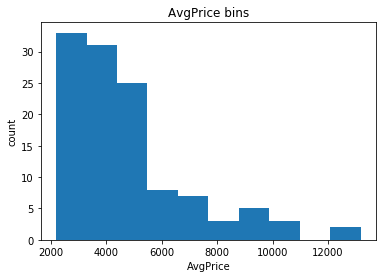

In [17]:

plt.pyplot.hist(kol_housing_price_final["AvgPrice"])

# set x/y labels and plot title
plt.pyplot.xlabel("AvgPrice")
plt.pyplot.ylabel("count")
plt.pyplot.title("AvgPrice bins")

In [18]:
kol_housing_price_final["AvgPrice"]=kol_housing_price_final["AvgPrice"].astype(int, copy=True)

In [19]:
price_bins = np.linspace(kol_housing_price_final["AvgPrice"].min(), kol_housing_price_final["AvgPrice"].max(), 6)
price_bins

array([ 2189. ,  4386.2,  6583.4,  8780.6, 10977.8, 13175. ])

In [20]:
group_names = ['Eco', 'Low', 'Mid', 'High', 'MHigh']
kol_housing_price_final['AvgPrice-Binned'] = pd.cut(kol_housing_price_final['AvgPrice'], price_bins, labels=group_names, include_lowest=True )

In [21]:
#rearrange the column sequence.................................................................
kol_housing_price_final = kol_housing_price_final[['LocalityName','MinPrice','MaxPrice','AvgPrice','AvgPrice-Binned', 'Latitude','Longitude','Distance']]

In [22]:
# Data set with price Binn
kol_housing_price_final.head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance
0,Bally,"2,338","2,932",2635,Eco,22.646958,88.343612,8.53
1,Belur,"2,508","3,442",2975,Eco,22.635732,88.339822,7.44
2,Bhadrakali,"2,338","2,678",2508,Eco,22.674365,88.343289,11.51
3,Chandannagar,"2,550","3,018",2784,Eco,22.861472,88.370607,32.13
4,Hindmotor,"1,955","2,550",2252,Eco,22.683216,88.348237,12.40


In [ ]:
#Temporary Read CSV

In [23]:
kol_housing_price_final = pd.read_csv (r'C:\abcl\IBM_LEARNING\DATA SCIENCE CERTIFICATION\9 Applied Data Science Capstone\kol_housing_price_final-Modify.csv') 

In [ ]:
# Venus details for each Locality............................................

In [24]:
CLIENT_ID = 'CWZGPTMQUSXYFQ3S4HGDBKOFRPLKFZ5B1IYZX2ZTDLOU5XU1' # your Foursquare ID
CLIENT_SECRET = 'YHQ23VZ2DTOMRHHKLES5QI3SI12IAOS1LDKBAYQDGL50KM0S' # your Foursquare Secret

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    VERSION = '20190612'
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
       # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            v['venue']['name'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['LocalityName', 
                  'Venue', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
kolkata_venues = getNearbyVenues(names=kol_housing_price_final['LocalityName'],
                                   latitudes=kol_housing_price_final['Latitude'],
                                   longitudes=kol_housing_price_final['Longitude']
                                  )

In [ ]:
# Kolkata Venue data by Foursquare API data 

In [27]:
kolkata_venues.head()

,LocalityName,Venue,Venue Category
0,Bally,Inox,Multiplex
1,Bally,Domino's Pizza,Pizza Place
2,Bally,Domino's Pizza,Pizza Place
3,Bally,Bally Halt,Bus Station
4,Bally,Sinthee More,Plaza


In [28]:
kolkata_venues_final = kolkata_venues.copy()

In [29]:
# Filter the Vanue categorys which are link to the Housing Price...........................................................

lst = ['Multiplex', 'Theater', 'Restaurant', 'Station', 'Airport', 'Bank', 'Grocery Store', 'Supermarket', 'Mall' ]
mask = np.logical_or.reduce([kolkata_venues_final['Venue Category'].str.contains(i, regex=False, case=False) for i in lst])
kolkata_venues_final = kolkata_venues_final[mask]

In [30]:
# Marge the Venue category by one, ie all Restaurant type venues into Restaurant, consider this is one feature............................................ 
kolkata_venues_final.loc[kolkata_venues_final['Venue Category'].str.contains("Restaurant"),'Venue Category']="Restaurant"

In [31]:
# Here again marge all 'Grocery Store', 'Supermarket', 'Mall' to 'Supermarket'.....................................................

lst = ['Grocery Store', 'Supermarket', 'Mall' ]
mask = np.logical_or.reduce([kolkata_venues_final['Venue Category'].str.contains(i, regex=False, case=False) for i in lst])

kolkata_venues_final.loc[mask,'Venue Category']='Supermarket'

In [32]:
# Kolkata Venue data after category filter...
kolkata_venues_final.head()

,LocalityName,Venue,Venue Category
0,Bally,Inox,Multiplex
3,Bally,Bally Halt,Bus Station
5,Bally,Liluah Railway Station,Train Station
6,Bally,Baranagar Road,Train Station
7,Belur,Inox,Multiplex


In [33]:
# one hot encoding for data modeling.........................................................................................
kolkata_venues_onehot = pd.get_dummies(kolkata_venues_final[['Venue Category']], prefix="", prefix_sep="")

# Add neighborhood column back to dataframe
kolkata_venues_onehot['LocalityName'] = kolkata_venues_final['LocalityName'] 

# Move neighborhood column to the first column
fixed_columns = [kolkata_venues_onehot.columns[-1]] + list(kolkata_venues_onehot.columns[:-1])
kolkata_venues_onehot = kolkata_venues_onehot[fixed_columns]


In [34]:
kolkata_venues_onehot = kolkata_venues_onehot.groupby('LocalityName').mean().reset_index()

In [35]:
#  For each Locality, marge all vanue by coma seperator.........................................................
list_cat = []
for ind in np.arange(kolkata_venues_onehot.shape[0]):
    vanue = ""
    for col in kolkata_venues_onehot.columns:
        if (col != "LocalityName" and col != "Airport Lounge" and col != "Indie Movie Theater") :
            if(kolkata_venues_onehot.get_value(ind, col) > 0):
                if vanue == "" :
                    vanue = col 
                else :   
                    vanue = vanue + ", " + col
    list_cat.append(vanue)

kolkata_venues_onehot["Vanues"] = list_cat;    

C:\ProgramData\WatsonStudioDesktop\miniconda3\envs\desktop\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys


In [36]:
# Finally created 2 dataframe's, one is used for modeling and another is for final output (Map)..............................................

kolkata_DF_Map = kol_housing_price_final.join(kolkata_venues_onehot[['LocalityName','Vanues']].set_index('LocalityName'), on='LocalityName')

In [37]:
kolkata_venues_onehot = kolkata_venues_onehot.drop('Vanues', 1)

In [38]:
kolkata_DF_Model = kolkata_venues_onehot.join(kol_housing_price_final[['LocalityName','AvgPrice', 'Distance']].set_index('LocalityName'), on='LocalityName')

In [39]:
# Kolkata Data set for modeling...
kolkata_DF_Model.head()

,LocalityName,Airport Lounge,Airport Service,Airport Terminal,Bank,Bus Station,Indie Movie Theater,Metro Station,Movie Theater,Multiplex,Restaurant,Supermarket,Train Station,Tram Station,AvgPrice,Distance
0,Action Area 1A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,4781,13.2
1,Action Area 1B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,4441,13.2
2,Action Area 1C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,4632,13.2
3,Action Area 1D,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,4399,13.2
4,Action Area I,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.666667,0.0,0.0,0.0,4632,19.4


In [40]:
# Kolkata Data set for Map (Final output)...
kolkata_DF_Map.head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues
0,Bally,"2,338","2,932",2635,Eco,22.646958,88.343612,8.53,"Bus Station, Multiplex, Train Station"
1,Belur,"2,508","3,442",2975,Eco,22.635732,88.339822,7.44,"Bus Station, Multiplex, Train Station"
2,Bhadrakali,"2,338","2,678",2508,Eco,22.674365,88.343289,11.51,"Bus Station, Train Station"
3,Chandannagar,"2,550","3,018",2784,Eco,22.861472,88.370607,32.13,Train Station
4,Hindmotor,"1,955","2,550",2252,Eco,22.683216,88.348237,12.40,"Bus Station, Train Station"


In [139]:
# Modeling......................................................

In [42]:
# Run k-means to cluster the neighborhood into 4 clusters.
# set number of clusters
kclusters = 4

kolkata_DF_Model_clustering = kolkata_DF_Model.drop('LocalityName', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kolkata_DF_Model_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 3, 3, 3, 3, 3, 3, 0, 0, 2])

In [43]:

# Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
# add clustering labels
kolkata_DF_Model.insert(0, 'Cluster Labels', kmeans.labels_)


# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
kolkata_DF_Map = kolkata_DF_Map.join(kolkata_DF_Model[['LocalityName','Cluster Labels']].set_index('LocalityName'), on='LocalityName')

kolkata_DF_Map.head() # check the last columns!



,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues,Cluster Labels
0,Bally,"2,338","2,932",2635,Eco,22.646958,88.343612,8.53,Multiplex,0.0
1,Belur,"2,508","3,442",2975,Eco,22.635732,88.339822,7.44,Multiplex,0.0
2,Bhadrakali,"2,338","2,678",2508,Eco,22.674365,88.343289,11.51,"Bus Station, Train Station",0.0
3,Chandannagar,"2,550","3,018",2784,Eco,22.861472,88.370607,32.13,Train Station,0.0
4,Hindmotor,"1,955","2,550",2252,Eco,22.683216,88.348237,12.40,"Bus Station, Train Station",0.0


In [44]:
# Remove the none value record...................
kolkata_DF_Map = kolkata_DF_Map.dropna()


In [ ]:
# Model Evaluation...............................................................

In [ ]:
#  1.  Elbow Method...................................................................

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot

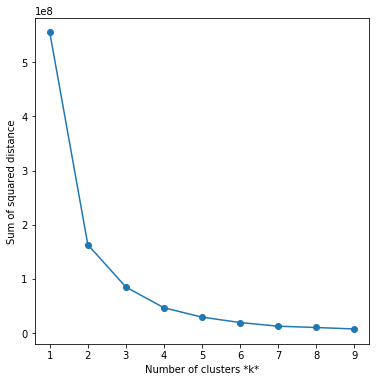

In [46]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(kolkata_DF_Model_clustering)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [ ]:
#  2.  Silhouette Analysis...................................................................

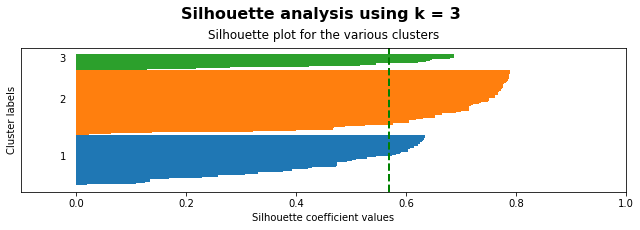

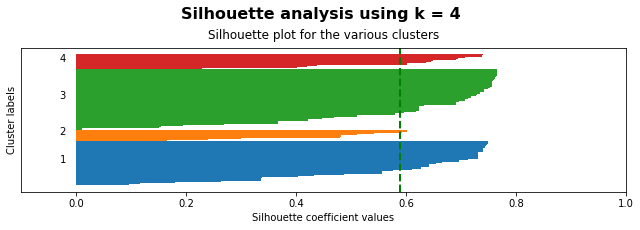

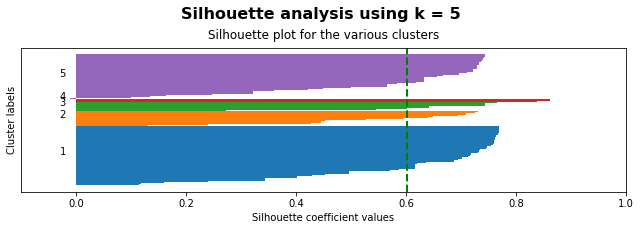

In [47]:
for i, k in enumerate([3, 4, 5]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(9, 3)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(kolkata_DF_Model_clustering)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(kolkata_DF_Model_clustering, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

In [51]:
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(kolkata_DF_Model_clustering)
    score = silhouette_score(kolkata_DF_Model_clustering, kmeans.labels_)
    silhouette_coefficients.append(score)

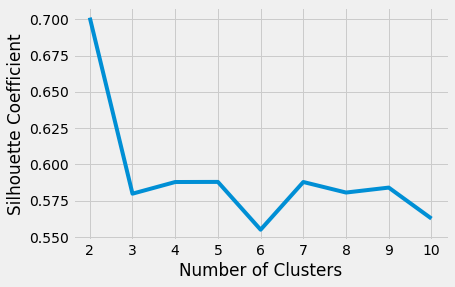

In [52]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [ ]:
#   RESULT...............................................................................................................................

In [ ]:
# Used python folium library to visualize Kolkata locality’s along with housing price range and price category and related venues as bellows

In [53]:
# Finally, let's visualize the resulting clusters
# create map
kol_latitude = float('22.5726')
kol_longitude = float('88.3639')

map_clusters = folium.Map(location=[kol_latitude, kol_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, loc, cluster, minPrice, maxPrice, pbinned, venues in zip(kolkata_DF_Map['Latitude'], kolkata_DF_Map['Longitude'], kolkata_DF_Map['LocalityName'], kolkata_DF_Map['Cluster Labels'], kolkata_DF_Map['MinPrice'], kolkata_DF_Map['MaxPrice'], kolkata_DF_Map['AvgPrice-Binned'], kolkata_DF_Map['Vanues']):
    cluster = int(cluster)
    label = folium.Popup(str(loc) + ' Cluster ' + str(cluster) + ' Price : ' + str(pbinned) + ' (Rs '+ str(minPrice) + ' - ' + str(maxPrice) + ')' + '\n' + ' Major Venues : ' + str(venues), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



In [ ]:
# The total Kolkata Locality Housing data has been Clustered by 4 and each cluster represent the category of price, let’s look each cluster locality data

In [54]:
#Cluster 1
kolkata_DF_Map.loc[kolkata_DF_Map['Cluster Labels'] == 0 ].head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues,Cluster Labels
0,Bally,"2,338","2,932",2635,Eco,22.646958,88.343612,8.53,Multiplex,0.0
1,Belur,"2,508","3,442",2975,Eco,22.635732,88.339822,7.44,Multiplex,0.0
2,Bhadrakali,"2,338","2,678",2508,Eco,22.674365,88.343289,11.51,"Bus Station, Train Station",0.0
3,Chandannagar,"2,550","3,018",2784,Eco,22.861472,88.370607,32.13,Train Station,0.0
4,Hindmotor,"1,955","2,550",2252,Eco,22.683216,88.348237,12.40,"Bus Station, Train Station",0.0


In [55]:
#Cluster 2
kolkata_DF_Map.loc[kolkata_DF_Map['Cluster Labels'] == 1 ]

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues,Cluster Labels
22,Chingrighata,"5,865","6,672",6268,Low,22.558656,88.410802,5.06,"Bus Station, Movie Theater, Multiplex, Restaur...",1.0
24,E M Bypass,"5,950","7,608",6779,Mid,22.489662,88.395403,14.40,"Bus Station, Metro Station, Multiplex, Restaur...",1.0
29,Tangra,"5,610","6,588",6099,Low,22.556511,88.379595,2.41,"Multiplex, Restaurant, Supermarket",1.0
46,Chetla,"6,332","8,202",7267,Mid,22.514325,88.336958,7.05,"Movie Theater, Multiplex, Restaurant, Supermarket",1.0
58,Jodhpur Park,"6,970","8,798",7884,Mid,22.505606,88.363674,7.45,"Multiplex, Restaurant, Supermarket",1.0
64,Mominpore,"7,055","7,438",7246,Mid,22.527053,88.326099,6.38,"Movie Theater, Multiplex, Restaurant",1.0
70,Panchasayar,"5,568","7,012",6290,Low,22.479430,88.391042,10.73,"Metro Station, Multiplex, Restaurant, Supermarket",1.0
71,Park Circus,"6,970","9,435",8202,Mid,22.540566,88.373860,3.71,"Multiplex, Restaurant, Supermarket",1.0
81,Tara Park,"6,375","6,842",6608,Mid,22.590686,88.304942,6.38,"Multiplex, Restaurant, Supermarket, Train Station",1.0
99,Kankurgachi,"6,885","8,670",7777,Mid,22.578972,88.391517,2.92,"Movie Theater, Multiplex, Restaurant, Supermar...",1.0


In [56]:
#Cluster 3
kolkata_DF_Map.loc[kolkata_DF_Map['Cluster Labels'] == 2 ].head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues,Cluster Labels
31,Alipore,"11,262","15,088",13175,MHigh,22.539171,88.327278,5.29,"Movie Theater, Multiplex, Restaurant, Supermarket",2.0
32,Anandapur,"8,500","9,308",8904,High,22.514839,88.409788,14.60,"Bus Station, Multiplex, Restaurant, Supermarket",2.0
34,Ballygunge,"9,392","12,452",10922,High,22.525881,88.366047,5.20,"Multiplex, Restaurant, Supermarket",2.0
35,Ballygunge Circular Road,"11,092","14,280",12686,MHigh,22.539594,88.358439,3.71,"Multiplex, Restaurant, Supermarket",2.0
36,Ballygunge Place,"9,350","10,795",10072,High,22.526946,88.370324,5.12,"Multiplex, Restaurant, Supermarket",2.0


In [57]:
#Cluster 4
kolkata_DF_Map.loc[kolkata_DF_Map['Cluster Labels'] == 3 ].head()

,LocalityName,MinPrice,MaxPrice,AvgPrice,AvgPrice-Binned,Latitude,Longitude,Distance,Vanues,Cluster Labels
13,Action Area 1A,"4,462","5,100",4781,Low,22.559524,88.491716,13.2,"Multiplex, Restaurant",3.0
14,Action Area 1B,"4,208","4,675",4441,Low,22.559524,88.491716,13.2,"Multiplex, Restaurant",3.0
15,Action Area 1C,"4,420","4,845",4632,Low,22.559524,88.491716,13.2,"Multiplex, Restaurant",3.0
16,Action Area 1D,"4,208","4,590",4399,Low,22.559524,88.491716,13.2,"Multiplex, Restaurant",3.0
17,Action Area I,"4,420","4,845",4632,Low,22.579769,88.462189,19.4,"Bus Station, Multiplex, Restaurant",3.0
